# **Paying Attention to Transformers**

<img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png" width="40%" />

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/hugginface_section/attention_and_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [THIS SHOULD STILL CHANGE TO OUR PRAC]

© Deep Learning Indaba 2022. Apache License 2.0.

**Authors:**

**Introduction:** 

[Intro to the topic. Probably between 3-5 lines.]

**Topics:** 

Content: <font color='blue'>`Attention mechanisms, Transformers, NLP`</font>  
Level: <font color='grey'>`Advanced`</font>


**Aims/Learning Objectives:**

- Learn how different attention mechanisms can be implemented.
- Learn and create the basic building blocks from scratch for the most common transformer architectures.
- Learn how to train a sequence-sequence model.
- Create and train a small GPT inspired model.
- Learn how to use the [Hugging Face](https://huggingface.co/) library for quicker development cycles.

**Prerequisites:**

- Basic understanding of Jax and Haiku
- Basic understanding linear algebra
- RNN based sequence-sequence models
- Token/Word embedding techniques

**Outline:** 


**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

## Installation and Imports

In [ ]:
## Install and import anything required. Capture hides the output from the cell. 
#@title Install and import required packages. (Run Cell)
!pip install git+https://github.com/deepmind/dm-haiku flax
!pip install transformers==4.12.1 datasets 
!pip install seaborn umap-learn

import os
import math

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
  print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  print("Only CPU accelerator is connected.")

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import haiku as hk
from transformers import pipeline
import datasets

import flax
import optax

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
#@title Helper Functions. (Run Cell)
def plot_projected_embeddings(embeddings, labels):
  import umap
  import seaborn as sns

  projected_embeddings = umap.UMAP().fit_transform(embeddings)

  plt.figure(figsize=(15,8))
  plt.title('Projected text embeddings')
  sns.scatterplot(
      x=projected_embeddings[:,0],
      y=projected_embeddings[:,1],
      hue=labels
  )
  plt.show()

In [ ]:
#@title Check what device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

## **Attention**

[Content on why we need attention, how something like RNN tried to tackle the problem, and how we got to attention.]

[Roughly 30 to 35 minutes]

[Currently, we still need some math tasks (if we can not think of anything, leave out)]

### Initial attention mechanisms - <font color='blue'>`Beginner`</font>

[Can talk about how an RNN auto-encoder used attention between current states and previous hidden-states, and code up some of those attention mechanisms (such as dot product, additive and multiplicative attention)]

[ Can use [Attention? Attention!](https://lilianweng.github.io/posts/2018-06-24-attention/) or something similar for guidance]


**Dot product attention**

[talk about dot product and how it can be used for attention]

[Code up the attention implimentation]

In [ ]:
def dot_product_attention(hidden_state, current_state):
  raise NotImplementedError

**Multiplicative attention (or something else)**

[talk about multiplicative and how it can be used for attention and how it adds in learnable parameters]

[Code up the attention implimentation]

In [ ]:
def multiplicative_attention(hidden_state, current_state):
  raise NotImplementedError

### Self-attention - <font color='blue'>`Intermediate`</font>

Talk about how we progressed to self-attention mechanisms and deep dive into scaled dot product attention. Not important yet to know how it fits into MHA.

#### **Scaled dot product attention**

[Deep dive here, with intuition for what query, keys and values can be, why we scale it etc.]

[Focus on query, value and key matrices code in MHA section when we build the MHA block of code to be used in transformer models]

**Code Task:** Can you code up scaled dot product attention?

In [ ]:
# we need to code up from scratch the function
def scd_attention(query, key, value):

  # allow then to code up the formula on their own
  raise NotImplementedError

In [ ]:
# run to test your function

def check_scd_attention_function(scd_attention_function):
  # we still need to impliment this
  raise NotImplementedError

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 

def scd_attention(query, key, value):
  emb_dim = query.shape[-1]
  logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
  scaled_logits = logits/jnp.sqrt(emb_dim)
  attention_weights = jax.nn.softmax(scaled_logits, axis=-1) 
  values = jnp.matmul(attention_weights, value)
  return values, attention_weights

#### **Masked scaled dot attention** 

[Talk about how in some cases we are not allowed to see into the future or other inputs, so now we add in the masked attention]

[Build upon the function above and add in mask]

**Code Task:** Try and implement the masking operation for your SCD function.

In [ ]:
# Code to be implemented during practical
def scd_with_mask_attention(query, key, value, mask=None):
  # CHANGE ME 
  raise NotImplementedError

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

def scd_with_mask_attention(query, key, value, mask=None):
  emb_dim = query.shape[-1]
  logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))

  if mask is not None:
    logits = jnp.where(mask, logits, -1e30) # same big negative value used in Haiku

  scaled_logits = logits/jnp.sqrt(emb_dim)
  attention_weights = jax.nn.softmax(scaled_logits, axis=-1) 
  attention = jnp.matmul(attention_weights, value)
  return attention, attention_weights


**Group Task:**

- Play with the mask you provide to your function and tell your friend what you see.
- Ask your friend if they think it's fair that we don't allow specific models to look into the future using self-attention.

### Multihead Attention - <font color='green'>`Advanced`</font>

[Introduce the concept of MHA and why it can be useful in a models.]

[Talk about projecting Q,K,V to smaller dimensions to make training more efficient etc.]

[Code up haiku multi-head attention module that will be used in future transformer models]

**Code Task:** Code up a Haiku module that implements the entire multi-head attention mechanism. 


In [ ]:
class MultiHeadAttention(hk.Module):

  def __init__(
      self,
      num_heads,
      key_size,
      model_size = None,
      name = None,
  ):
    super().__init__(name=name)
    self.num_heads = num_heads
    self.key_size = key_size
    self.model_size = model_size or key_size * num_heads

  def __call__(self, query, key, value, mask = None):
    raise NotImplementedError


In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

# TODO: ADD IN CORRECT ANSWER


**MHA vs other sequence methods (optional)**

[Talk about how it differs and the complexity differs and other differences. Like what was done in this [practical](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html)]

### Section Quiz 

[Test knowledge on all the previous material of attention]

In [ ]:
#@title Generate Quiz Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/zbJoTSz3nfYq1VrY6",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

## **Transformers**


[Roughly 75 to 90 minutes]

[Introduce the transformer architecture, starting with the vanilla transformer introduced in attention all you need]

[Focus on building up now the entire transformer encoder-decoder architecture. We can discuss how deep we go into tokenization and positional encodings.]

[Build a transformer encoder-decoder model that can change the input sequence order, most likely using helper functions to load and produce training batches.]

[Build a decoder-only architecture, inspired by mini-gpt, that can predict the next character in a sentence, using helper functions that loads and produces training batches]

[Introduce beam search and other sampling techniques or just greedy for this practical?]

### Section Quiz 

Optional end of section quiz. Below is an example of an assessment.

In [ ]:
#@title Generate Quiz Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/zbJoTSz3nfYq1VrY6",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

## **Hugging Face**



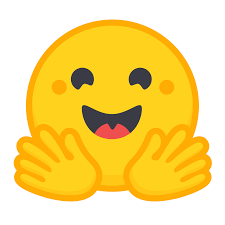


[Hugging Face](https://huggingface.co/) is a startup founded in 2016 and, in their own words: "are on a mission to democratize good machine learning, one commit at a time."

They have developed various open-source packages and allow users to easily interact with a large corpus of pretrained transformer models (across all modalities) and datasets to train or fine-tune pre-trained transformers.

Their software is used widely in industry and research. The following sections show how one can interact with their various features, access SOTA models, and train your own model.

This is an optional section for the practical. Still, working through it in the practical or afterwards is highly recommended. Understanding Hugging Face will allow you to build a very quick proof of concept system to test out various hypotheses, whereafter, the system you build can simply be used, or a new system can be developed with the knowledge that the original idea has merit. 

It should also be noted that various languages are still severely under-resourced, even in this ecosystem. See it as an opportunity also to see where the gaps are and how we as a community can reduce this gap. 

### Datasets Package - <font color='blue'>`Beginner`</font>

Along with all the models being availible, datasets are also hosted on the hugginface hub. One can visit the [dataset hub](https://huggingface.co/datasets), and browse for interesting datasets and very easilly access it through the [datasets](https://github.com/huggingface/datasets) package.

Lets say for instance we want to build an text intent classification model. What we do then is to go to the link above, and use the search tags to find a dataset that seems like a good fit for us. Doing this, we find the [`banking77`](https://huggingface.co/datasets/banking77) dataset. Below we then load in this dataset.


In [ ]:
# just for notebook cleanliness
from datasets.utils.logging import set_verbosity_error
from datasets import load_dataset

dataset = load_dataset("banking77")
print(dataset)

Here we see that the API returns a variable of DatasetDict type, which containins our dataset that has split into two datasets, i.e. train and test splits. We also see that each of these datasets contain `text` and `label` features. 

Lets investigate how the data looks.

In [ ]:
dataset['train']

We see that our dataset splits are of type Dataset.

In [ ]:
train_intents = dataset['train']
test_intents = dataset['test']

print('Text: ', train_intents['text'][0])
print('Label: ', train_intents['label'][0])

Sometimes we want to work with only a subset of the dataset and we thus need to filter out the rest. Luckilly, the datasets have an easy to use filter functionality. Below we filter to only see text which relates to label 11. 

In [ ]:
# we are only the first 5 text samples
train_intents.filter(lambda data: data['label']==1)

We can also apply a function to each data item by mapping the function to each "row" in the dataset.

In [ ]:
# creating small dataset as example of using select
example_dataset = train_intents.select(range(10))

# printing first character of a text example
example_dataset.map(lambda example: print(example['text'][0]));

Using the map function, we can also add a new collumn.

In [ ]:
def add_sentence_len(example):
    example['lenght'] = len(example['text'])
    return example

# add new column
example_dataset = example_dataset.map(lambda example: add_sentence_len(example))

print(example_dataset)
print('New data:', example_dataset['lenght'])

**Code Task**: 
- We want to build a classifier out of this. We need to investigate the distrubution of classes to see if our dataset is balanced or not. Write code that generates a dictionary containing the count of each class for both the train and test dataset.
- Filter out classes with less than 150 classes in the training set, and ensure only the remaining classes are in the test test. 

In [ ]:
# task 1
unique_labels = # FINISH ME
total_unique_labels = # FINISH ME

train_counts = # FINISH ME
test_counts = # FINISH ME

# task 2
passed_labels = [label for label, count in train_counts.items() if count>=150]
train_intents = # FINISH ME
test_intents = # FINISH ME

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

# # task 1
unique_labels = np.unique(train_intents['label'])
total_unique_labels = len(unique_labels)

train_counts = {label:sum(label==train_intents['label']) for label in unique_labels}
test_counts = {label:sum(label==train_intents['label']) for label in unique_labels}

# task 2
passed_labels = [label for label, count in train_counts.items() if count>=150]
train_intents = train_intents.filter(lambda data: data['label'] in passed_labels)
test_intents = test_intents.filter(lambda data: data['label'] in passed_labels)

**Other modalities**

Text is not the only data that can be accessed, audio and image data can be accessed just as easilly. 

In [ ]:
# loading audio
from PIL import Image
from io import BytesIO

dataset = load_dataset("cgarciae/cartoonset")
Image.open(BytesIO(dataset['train']["img_bytes"][231]))

del dataset

### Transformers Package

Now that we have a way in accessing data, lets shift our intention to accessin the hundreds of pretrained transformers.

#### Pipeline - <font color='blue'>`Beginner`</font>

The easiest method to access a vast range of pre-trained models and use tasks is through the `pipeline` API.

Pipelines group together a pretrained model found on their models hub with the preprocessing that was used during that model's training. To use the pipeline, one must import it from the [transformers](https://github.com/huggingface/transformers) library and specify the task and model you want.

For a list of models, visit [this](https://huggingface.co/models) page that allows you to search through all models currently on the hub.

In [ ]:
# When calling the function for the first time, the model, and its tokenizer, will be automatically downloaded
sentiment_model = pipeline(task='sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')
print(sentiment_model("I love this practical!"))
print(sentiment_model("I hate this practical!"))

# passing more than one sentence
sentence_batch = [
  'This is much quicker and easier to build a POC with than training everything from scratch',
  'It really hurts when I stub my toe',
  'I want to get ice cream'
]
print('\nBatch output:')
sentiment_model(sentence_batch)

Notice that the first sentence we process in our batch of sentences is predicted to be Negative, with a relative low score of $0.51$, even though we feel this should be more neutral? The low score indicates this and we can interepet that when scores are low the actual label was meant to be Neutral, but this model was trained to do a binary prediction only.

This model you just used is a Distellbert model, which was trained on *8 16GB V100s for 90 hours*, and you could use it as quickly as that.

**Code Task:** Apply the zero shot model to all of our test intent chatbot examples, extracting the predicted senitment label into a new collumn, using the map function.

In [ ]:
def get_sentiment(example):
  # FINISH ME
  return sentiment

train_intents = # FINISH ME
test_intents = # FINISH ME

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

def get_sentiment(example):
  example['sentiment'] = sentiment_model(example['text'])[0]['label']
  return example

test_intents = test_intents.map(lambda example: get_sentiment(example))

In [ ]:
plt.title('Count of positive versus negative text inputs')
sns.countplot(test_intents['sentiment']);

**Group code task (optional depending on time)**: (Hint: use the tags when searching the [model hub](https://huggingface.co/models))
- Search for other pipeline tasks available, and dicuss with your friend what you did and found. ([Hint](https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/pipelines#pipelines))
- Play with different language models and see how they perform

In [ ]:
your_pipeline = pipeline(
    task='text-generation', # CHANGE ME TO OTHER STUFF
    model='gpt2' # CHANGE ME AS WELL
)
text = 'I like ice-cream and '
your_pipeline(text)

In [ ]:
# freeing up memory for future tasks
del your_pipeline
del sentiment_model

#### Training a chatbot intent model  - <font color='blue'>`Advanced`</font>

If you want more controll than the pipeline API provides you, you can also use the predefined model classes. 

To showcase this, we will be training a custom model on top of a large transformer.

To set the scene, lets say for instance that we want to train an intent model that can be used along with a chatbot. This intent model will be responsible to predict the true underlying intent found within the text. 

Your imaganiry friend has built an intent model using TF-IDF techniques, but you think that you can use transformers for this task and that it will perform better. 

You have heard about the famous [DistilBERT](https://arxiv.org/pdf/1910.01108.pdf) model that was trained to extract text features, and yout think this model can be a perfect fit to extract features for your intent model, as it is an encoder only transformer architecture that produces strong token representations.

To start your training process, you have two steps to follow:

* Get the tokenizer
* Get the model

###### **Getting the tokenizer**

A tokenizer is responsible for preprocessing text into a format that is understandable to the model. It is very important to use the same tokenizer as the model you will be finetuning.  

In [ ]:
# we want the Distilbert model, thus we import the correct tokenizer the model train
from transformers import DistilBertTokenizer

# we specify a specif distilbert 
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

print('Tokenizer output:')
output = tokenizer('This is example text')
print(output)

print('Tokens converted back to string')
print(tokenizer.decode(output['input_ids']))

Looking at the output from the above, we that the special tokens are the `[CLS]` and `[SEP]` tokens. This is important to note, as we will be using the final output of the model for the `[CLS]` token when predicting the intent. 

This is a very common thing to do, where the token that indicates the start of the sentence is used when making predictions on the sentence. Seeing as our system is built in Jax, we will need to tell the tokenizer to return the data in the correct format.


In [ ]:
token_batch = tokenizer(
    ["We are very happy to show you the 🤗 Transformers library.", "We hope you don't hate it."],
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="jax",
)
print(token_batch)

Seeing as we want to use these tokens throughout our training process and for processing the embeddings, lets map the tokenizer output to new collumn for our train and test splits.

##### **Getting the transformer and generating embeddings**

No that we can encode our text quickly into data that our transformer can processes, let gather and download the pretrained transformer model from the hub and generate representations for each text example.

As was mentioned above, we are interested for now only in the `[CLS]` token embedding. One can ofcourse look at averaging over all token (being sure to only use tokens who are note masked) and see how it compares. We leave this as an excersise for the reader to compare how it changes the performance of the model.


In [ ]:
from transformers import FlaxDistilBertModel

# we use FlaxDistillBertModel because we are in the JAX world
distell_bert_model = FlaxDistilBertModel.from_pretrained(model_name)

tokens = tokenizer([train_intents[0]['text']])
embeddings = distell_bert_model(**tokens)[0][:,0]
embeddings.shape

Applying one by one is extremely slow, so lets rather infer in batches, using the `batch` flag in the map function. It is important here that the function that is being mapped works with batches and return the data in the correct format, i.e a dictionary with the new column name.

In [ ]:
def get_embedding(batch):

  text = batch['text']
  tokens = tokenizer(
      text,
      padding=True,
      truncation=True,
      max_length=50,
      return_tensors="jax",
  )

  cls_embeddings = np.array(distell_bert_model(**tokens)[0][:,0])
  return {'embedding':cls_embeddings}

train_intents = train_intents.map(lambda batch: get_embedding(batch), batched=True)
test_intents = test_intents.map(lambda batch: get_embedding(batch), batched=True)

To see whether these embeddings are in anyway usefull, lets plot a few projected embeddings and their labels and see how it looks. 

In [ ]:
# Sampling to get a clear picture with less data.
sample_labels = [5,11,20,28,34,45,51,76]
plot_data = train_intents.filter(lambda data: data['label'] in sample_labels)
plot_projected_embeddings(plot_data['embedding'], [str(l) for l in plot_data['label']])

We see there are clear clusters forming, but there is defnitely still some work that can be done here.

Lets thus train a non linear model on this data to try and find something that seperate this intents.

We have a choice really of what we want to do, given data our new dataset can just be interpeted as a database. We can either train another neural netwok, or we can train anything ranging from a logistic regression model to a XGBoost model.

Lets start by training a neural network, as we are at the deep learning indaba ;)

In [ ]:
# extracting data into more usable state for all methods
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() # labels should be from 0 - N

train_embeddings = train_intents['embedding']
train_labels = jnp.array(le.fit_transform(train_intents['label']))
test_embeddings = test_intents['embedding']
test_labels = jnp.array(le.transform(test_intents['label']))

In [ ]:
import tensorflow as tf
# creating tensorflow dataset loaders
train_ds = tf.data.Dataset.from_tensor_slices((train_embeddings,train_labels))
train_ds = train_ds.\
  shuffle(buffer_size=len(train_embeddings),reshuffle_each_iteration=True).\
  batch(64)

test_ds = tf.data.Dataset.from_tensor_slices((test_embeddings,test_labels))
test_ds = test_ds.batch(64)

##### **Training intent model**

Even though the methods below only show us updating the weights or parameters of downstream models, there is now reason that one can not finetune the entire Distilbert model on the new dataset and task. This will just require much more compute and in many cases the extra costs are not linearly correlated with improved performance. This is why in this practical, why only train downstream models utilising the pretrained embeddings.

###### MLP

Our intent model will be 2 layer MLP. 

**Code task:** Finish the 2 layer MLP Haiku Module.

In [ ]:
# build a training model

class IntentClassifier(hk.Module):
  """A MLP which predicts intent from transformer embeddings"""

  def __init__(self):
    super().__init__()
    self._init_scale = .5
    self.number_classes = #FILL ME IN

  def __call__(self, embeddings):
    embedding_size = # FILL ME IN
    initializer = hk.initializers.VarianceScaling(self._init_scale)
    projection_layer = hk.Linear(embedding_size, w_init=initializer)
    classification_layer = # FILL ME IN

    projections = jax.nn.relu(projection_layer(embeddings))

    logits = # FILL ME IN
    return logits

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

# build a training model

class IntentClassifier(hk.Module):
  """A MLP which predicts intent from transformer embeddings"""

  def __init__(self):
    super().__init__()
    self._init_scale = .5
    self.number_classes = 38

  def __call__(self, embeddings):
    embedding_size = embeddings.shape[-1] 
    initializer = hk.initializers.VarianceScaling(
        self._init_scale)
    projection_layer = hk.Linear(
        embedding_size, 
        w_init=initializer
    )
    classification_layer = hk.Linear(
        self.number_classes,
        w_init=initializer
    )

    projections = jax.nn.relu(
        projection_layer(embeddings)
    )
    logits = classification_layer(projections)
    return logits

In [ ]:
def classify_intent(embeddings):
  model = IntentClassifier()
  return model(embeddings)

classify_intent = hk.transform(classify_intent)

# initialise model
rng = jax.random.PRNGKey(42)
x = np.zeros([1, 768])
params = classify_intent.init(rng, x)

optimiser = optax.adam(1e-3)
opt_state = optimiser.init(params)

In [ ]:
key = jax.random.PRNGKey(42)

def loss(params, batch):
  """Cross-entropy classification loss"""
  batch_size = len(batch['labels'])
  logits = classify_intent.apply(params,key, batch['embeddings'])
  labels = jax.nn.one_hot(batch['labels'], num_classes=38)
  log_likelihood = jnp.sum(labels * jax.nn.log_softmax(logits))
  return -log_likelihood / batch_size

In [ ]:
@jax.jit
def update(params, opt_state, batch):
  # get data neded for training
  grads = jax.grad(loss)(params, batch)
  updates, opt_state = optimiser.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state


@jax.jit
def accuracy(params, batch):
    predictions = classify_intent.apply(params, key, batch['embeddings'])
    print(predictions)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == batch["labels"])

In [ ]:
from tqdm import tqdm

# Training & evaluation loop.
for epoc in range(10):

  train_accs = 0
  total_calcs = 0
  for batch in tqdm(train_ds, desc='Train steps', leave=False):
    batch = {
        'embeddings':jnp.array(batch[0]),
        'labels':jnp.array(batch[1])
    }
    params, opt_state = update(params, opt_state, batch)
    train_accs+=accuracy(params, batch)
    total_calcs+=1

  if epoc%5==0:
    print(f'At epoch: {epoc}') 
    train_accs /= round(total_calcs,2)

    test_accs = 0
    total_calcs = 0

    for batch in tqdm(test_ds, desc='Test steps', leave=False):
      batch = {
          'embeddings':jnp.array(batch[0]),
          'labels':jnp.array(batch[1])
      }
      test_accs+=accuracy(params, batch)
      total_calcs+=1
    
    test_accs /= round(total_calcs,2)

    print(f'\nTrain accuracy:{train_accs}')
    print(f'Test accuracy:{test_accs}')

Now that we have a trained MLP that can predict the intent, we need to writ code that given new text, will classify an intent. 

In [ ]:
def predict_new_text_mlp(text):
  embedding = get_embedding({'text':[text]})['embedding']
  logits = classify_intent.apply(params, key, embedding)
  predicted_intent = jnp.argmax(jax.nn.softmax(logits))
  converted_back_intent = le.inverse_transform([predicted_intent])[0]
  print(f'Predicted intent for inpy "{text}" is {int(converted_back_intent)}')
  
  index = jnp.where(train_labels==predicted_intent)[0]
  print(f'Example training data from this class: {train_intents[index]["text"][0]}')

In [ ]:
predict_new_text_mlp('Can I get a refund please')

###### Logistic regression

As a final test, we will see how a logistic regression model performs against our MLP, and how quick it can be to get very quick results.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize

In [ ]:
model = LogisticRegression(max_iter=6000)
model.fit(train_embeddings, train_labels)
y_hat_train = model.predict(train_embeddings)
y_hat_test = model.predict(test_embeddings)

train_accuracy = jnp.sum(y_hat_train == train_labels)/len(y_hat_train)
test_accuracy = jnp.sum(y_hat_test == test_labels)/len(y_hat_test)

print(f'Train accuracy:{train_accuracy}')
print(f'Test accuracy:{test_accuracy}')

In [ ]:
def predict_new_text_lr(text):
  embedding = get_embedding({'text':[text]})['embedding']
  predicted_intent = model.predict(embedding)
  converted_back_intent = le.inverse_transform([predicted_intent])[0]
  print(f'Predicted intent for inpy "{text}" is {int(converted_back_intent)}')
  
  index = jnp.where(train_labels==predicted_intent)[0]
  print(f'Example training data from this class: {train_intents[index]["text"][0]}')

In [ ]:
predict_new_text_lr('Can I please get a refund')

As you can see, in just those few lines of code we have coded a logistic regression model that can classify the intent of a user given 

## Conclusion
**Summary:**

[Summary of the main points/takeaways from the prac.]

**Next Steps:** 

[Next steps for people who have completed the prac, like optional reading (e.g. blogs, papers, courses, youtube videos). This could also link to other pracs.]

**Appendix:** 

[Anything (probably math heavy stuff) we don't have space for in the main practical sections.]

**References:** 

[References for any content used in the notebook.]

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2022).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
#@title Generate Feedback Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />